# Imports

In [1]:
from utils import *
from paths_and_parameters import *

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [3]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [4]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 366


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [5]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [6]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [0]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels and wrong scale in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [7]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [10]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

phases_primary = [hydrocerussite, lazurite, cinnabar]

### Take them from file `phases_selection_primary.dat`

In [9]:
phases_primary = phases_from_file('phases_selection_primary.dat', database)

Loaded phases: Fe2 O3 1, Goethite 10, Hematite 9, Siderite 1


# Search for primary phases

### Change initial calibration
Adjust initial calibration. This can be executed after the first fit finds a better initial calibration.

In [11]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Create data structure

In [12]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [13]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.3 s, sys: 1.72 s, total: 13 s
Wall time: 16.5 s


#### Fast mapping

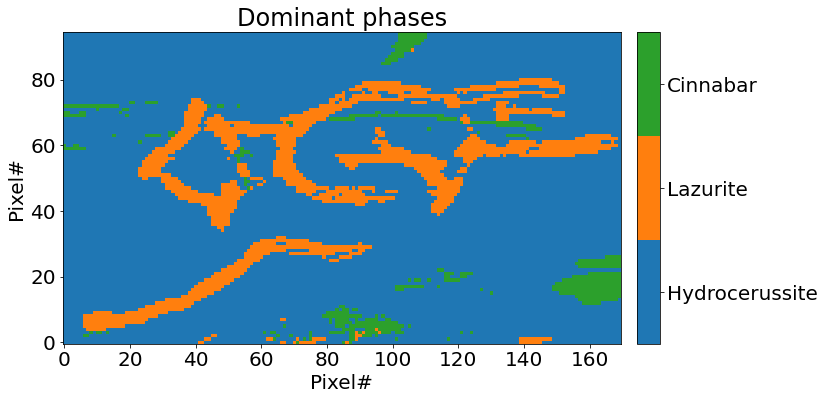

In [14]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

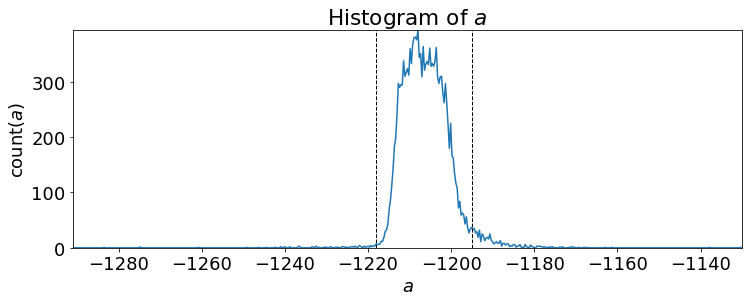

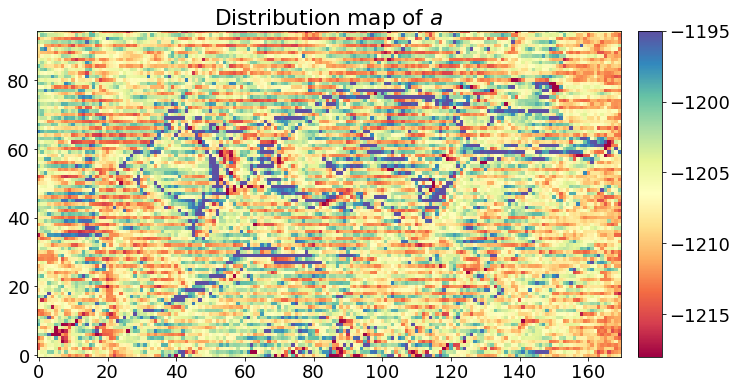

In [15]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1218
vmax = -1195

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
ax.plot(b[:-1], h)
ax.set_xlim(b[0], b[-1])
#ax.set_xlim(-1230, -1180) # TO CHANGE HORIZONTAL SCALE: set these value, otherwise leave this line commented
ax.set_ylim(0, h.max())
ax.vlines(vmin, 0, nanmax(h), 'k', ls = '--', lw = 1)
ax.vlines(vmax, 0, nanmax(h), 'k', ls = '--', lw = 1)
ax.set_xlabel('$a$')
ax.set_ylabel(r'count($a$)')
ax.set_title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
ax.set_title('Distribution map of $a$')
im = ax.imshow(a, interpolation = 'none', cmap = 'Spectral', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [-1.53899237 88.48670624]
Cauchy: [ -0.92219474 833.37764857]
mean a,s: -1205.9687842479443 1944.4634619430879
most probable a,s: -1208.005455481997 1947.3939251698184


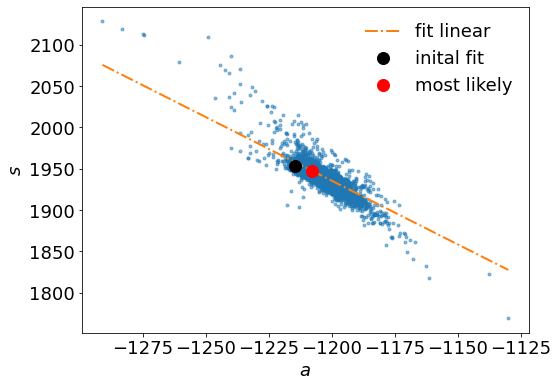

In [20]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[nanargmax(h)]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.5)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
ax.legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')

### TO SET HORIZONTAL AND VERTICAL SCALE ###
# If you prefer automatic scale, you can leave this options commented.
#ax.set_xlim(-1250, -1180)
#ax.set_ylim(1850, 2000)

savefig(path_figures + 'fit_a_s.png')
show()

# Quantify phase presence

In [21]:
correction = data.rescaling**0.5
criterion = overlap_area * correction

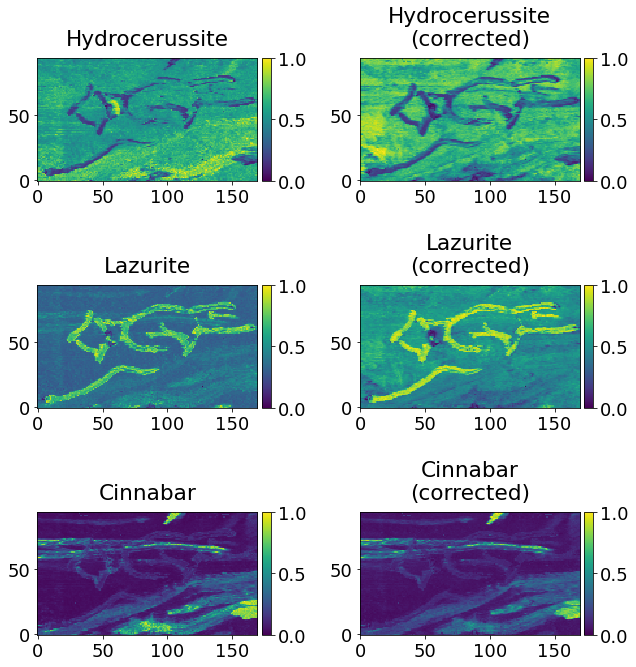

In [22]:
%matplotlib inline
rcParams['font.size'] = 18
position_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:        

            if (len(gm.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none')
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion[..., i] / criterion[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

# Fit errors

Plotting the histograms and maps of the error for each phase. 

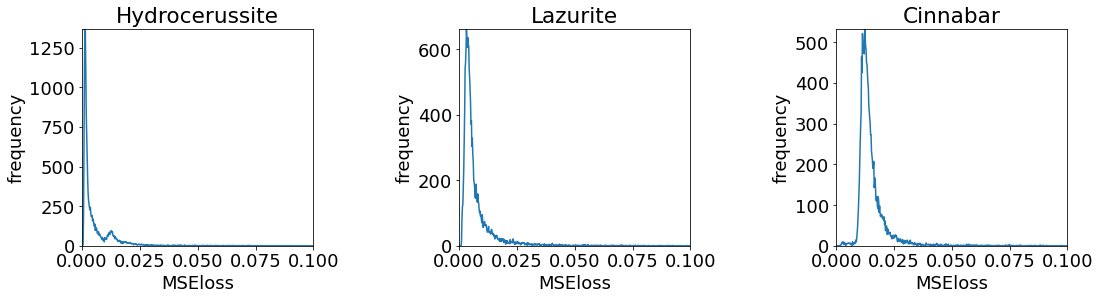

In [23]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[..., i], bins = 512, range = (0, 0.1))
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('MSEloss')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

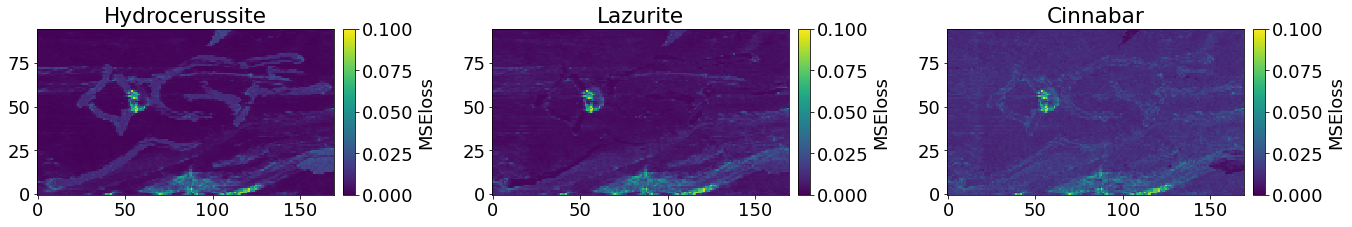

In [24]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 3, w_pad = 6)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    ax.set_title(phase.label)
    im = ax.imshow(MSEloss[..., i], interpolation = 'none', vmin = 0, vmax = 0.1)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    cbar.set_label('MSEloss')
show()

# Select secondary phases

### Manually select them

In [33]:
bone_black = database['Bone_Black'][0]
goethite = database['Goethite'][0]
hematite = database['Hematite'][4]
yellow_cd_zn_s = database['Cadmium zinc sulphide yellow'][0]

phases_secondary = [bone_black, goethite, hematite, yellow_cd_zn_s]

### Take them from file `phases_selection_secondary.dat`

In [25]:
phases_secondary = phases_from_file('phases_selection_secondary.dat', database)

Loaded phases: Jarosite 15, Pyrite 4


# Search for secondary phases

### Smooth data

In [26]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


### Check rescaling factor

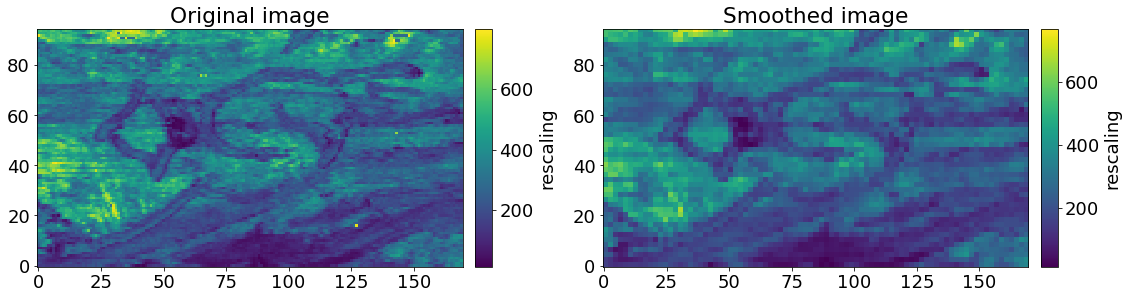

In [27]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

### Refit primary phases on smoothed data

In [28]:
%%time
gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm1 = gm1.search()

overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 13 s, sys: 1.6 s, total: 14.5 s
Wall time: 16.6 s


### Fit secondary phases on smoothed data

In [29]:
%%time

#phases_secondary = [bone_black, goethite, hematite]

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm2 = gm2.fit_cycle(steps = 6, gamma = True)

overlap_area_compare_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 15.5 s, sys: 4.9 s, total: 20.4 s
Wall time: 21.6 s


### Quantify phase presence

In [30]:
correction = data_smooth.rescaling**0.5
criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_compare_2 * correction

# Plots

### Primary phases

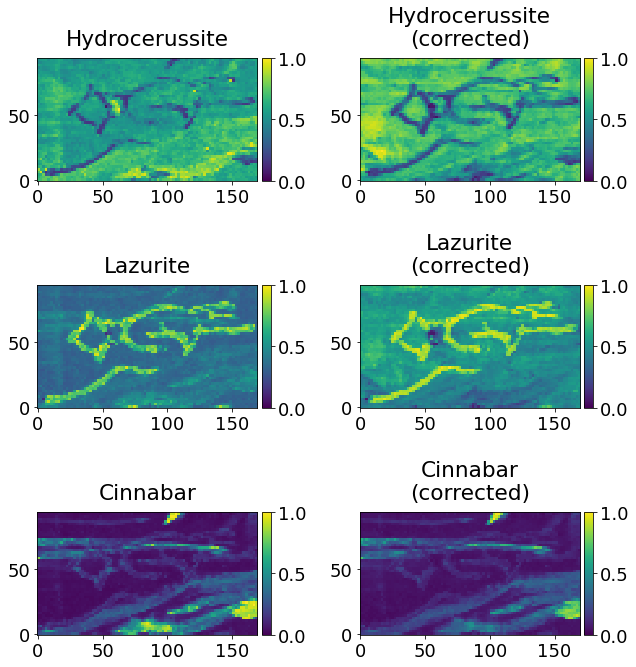

In [31]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm1.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm1.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm1.phases):
    if (len(gm1.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm1.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:

            if (len(gm1.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm1.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_1[..., i] / criterion_1[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Secondary phases

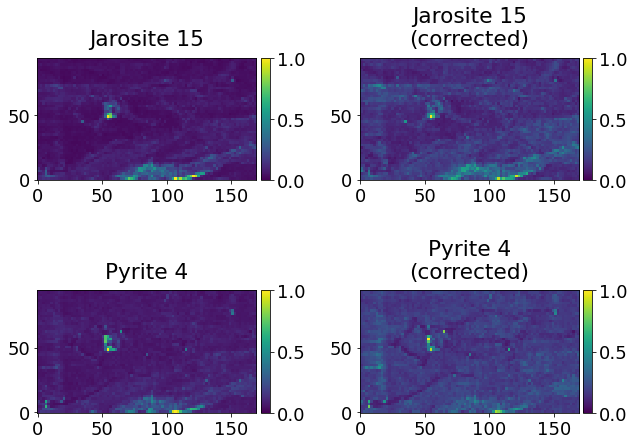

In [32]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm2.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm2.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm2.phases):
    if (len(gm2.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_compare_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm2.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:     

            if (len(gm2.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm2.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_2[..., i] / criterion_2[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

# Verify overlap of secondary phases in chosen pixel

Primary phases: 0.4976 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Jarosite 15:	0.0485
Pyrite 4:	0.0120


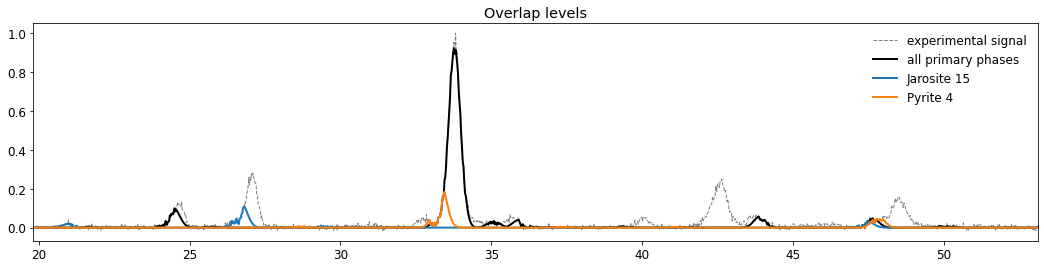

In [57]:
x, y = 20, 80
rcParams['font.size'] = 12

gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 4))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.4f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
    print(f'{gs2[j].label}:\t{gs2.overlap_area_compare()[j]:.4f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap levels')
show()